In [1]:
# disable FutureWarnings to have a cleaner output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# move to previouse directory to access the privugger code
import os, sys
sys.path.append(os.path.join("../.."))

# external libraries used in the notebook
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# privugger library
import privugger as pv

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Getting started with privugger

This tutorial shows a simple example on using privugger to analyze a program that computes the average of a set of ages. Privugger is based on the privug method introduced in [this paper](https://arxiv.org/abs/2011.08742)－you may want to have a look at the paper if some of the concepts explained below are new to you.

## Program to analyze

Privugger is a tool to quantify privacy risks in python _programs_. Consequently, the very first step is to define the program we want to analyze.

In this example, we consider a program computing the average of a list of ages. The program takes as input a `numpy` array whose elements are of type `Float` (each element correspond to an age).

In [2]:
def avg(ages):
    return (ages.sum()) / (ages.size)

At first sight, one might think that releasing publicly the output of the program should no pose any privacy. Let's verify whether this is the case with Privugger.

## Input specification (attacker knowledge about the input)

The next step in using privugger is to specify the knowledge of our (assumed) attacker about the input of the program. In other words, what are our assumptions on what the attacker knows about the ages used in this program?

In this example, we assume that the dataset contains the ages of 100 individuals, and that the attacker believes that the most likely age for the individuals is 35, but she is not certain about it.

The above attacker knowledge can be modeled with a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with mean 35 and some standard deviation to amount for the uncertainty (in this case we choose a standard deviation of 2).

In [3]:
# input spec
ages = pv.Normal('ages',mu=35,std=2,num_elements=100)

After we define the specification of the input, we wrap everything into a _dataset_. Datasets are objects modeling the input of the programs we want to analyze. In this case, our program of interest takes an array of ages. Consequently, the dataset constructor takes as only input the specification of this array (defined in the cell above).

If the program under analysis had more parameters, the `input_specs` parameter below should have as many elements as parameters in the program. The elements in `input_specs` do not necessarily need to be arrays, they can only be scalars. For instance, if ages if defined as `num_elements=1` then it models a single age.

In [4]:
# create a privugger dataset
ds = pv.Dataset(input_specs=[ages])

## Program specification

The next step is program specification. That is, we put together the program's code and the specification of the input. Additionally, we need to indicate the type of the output of the program.

In the cell below, we create a `Program` object that encapsulates the program specification. The parameter `dataset` takes a privugger `Dataset` matching the signature of the program to analyze. This program is specified in `function` which may be a python method or a file containing the method to analyze. Finally, in `output_type` we specify the type of the output of the program.

The program output distribution is automatically named `'output'`.

In [5]:
program = pv.Program(dataset=ds, 
                     output_type=pv.Float, 
                     function=avg)

## Observation specification

In this step, we may add an _observation_ to any of the program variables. Observations are predicates modeling binary inequalities. They have the form $a \, R \, b$ with $a, b \in \mathbb{N}$ or $a,b \in \mathbb{R}$ and $R \in \{<,>,=<,>=,==\}$. Additionally, observation have a `precision` parameter that allow us to model the strength of the observation. This is important as, e.g., in continuous domains the probability of any single outcome is 0. A precision of 0 requires the observation to hold with probability 1, the larger the precision the lower the probability require for the observation to hold.

Here we add an observation saying that the output equals 44 and with a precision of 0.1.

In [6]:
program.add_observation('output==44', precision=0.1)

## Inference

In this step, we infer the distributions of all the variables we defined above. We may choose different backends for this purpose. Currently we support [PyMC3](https://docs.pymc.io/en/stable/) (used in this example) and [scipy](https://www.scipy.org/).

The output of the `infer` method is a `InferenceData` compatible with many statistics libraries for plotting or computing statistics (see section below)

In [7]:
trace   = pv.infer(program, 
                   cores=4,
                   draws=10_000,
                   method='pymc3')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 4 jobs)
Slice: [ages]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 253 seconds.


## Posterior Analysis

Here we show some analysis we can perform with the trace generated using privugger.

### Distribution visualization

As a first example of analysis, we use the `arviz` library to visualize the distribution of the output of the `avg` program.

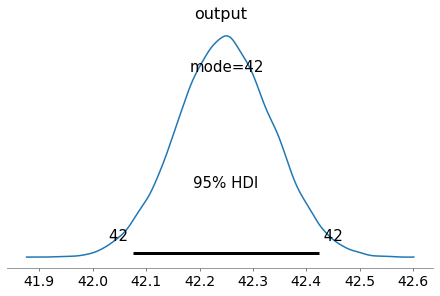

In [8]:
az.plot_posterior(trace, var_names=['output'], hdi_prob=.95, point_estimate='mode'); # plot the inferred distribution of the output

This plot indicates that values of the output of the `avg` between 42.0 and 42.5 are the most likely with anything else having probability < 0.05. This is due to the effect of the observation we set up earlier. 

We can also visualize the distribution of each of the elements in the dataset (recall the dataset consisted in a list of 10 elements modeling the age of different individuals)

/home/pardo/.local/lib/python3.8/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (100) in plot_posterior, generating only 40 plots
  warnings.warn(


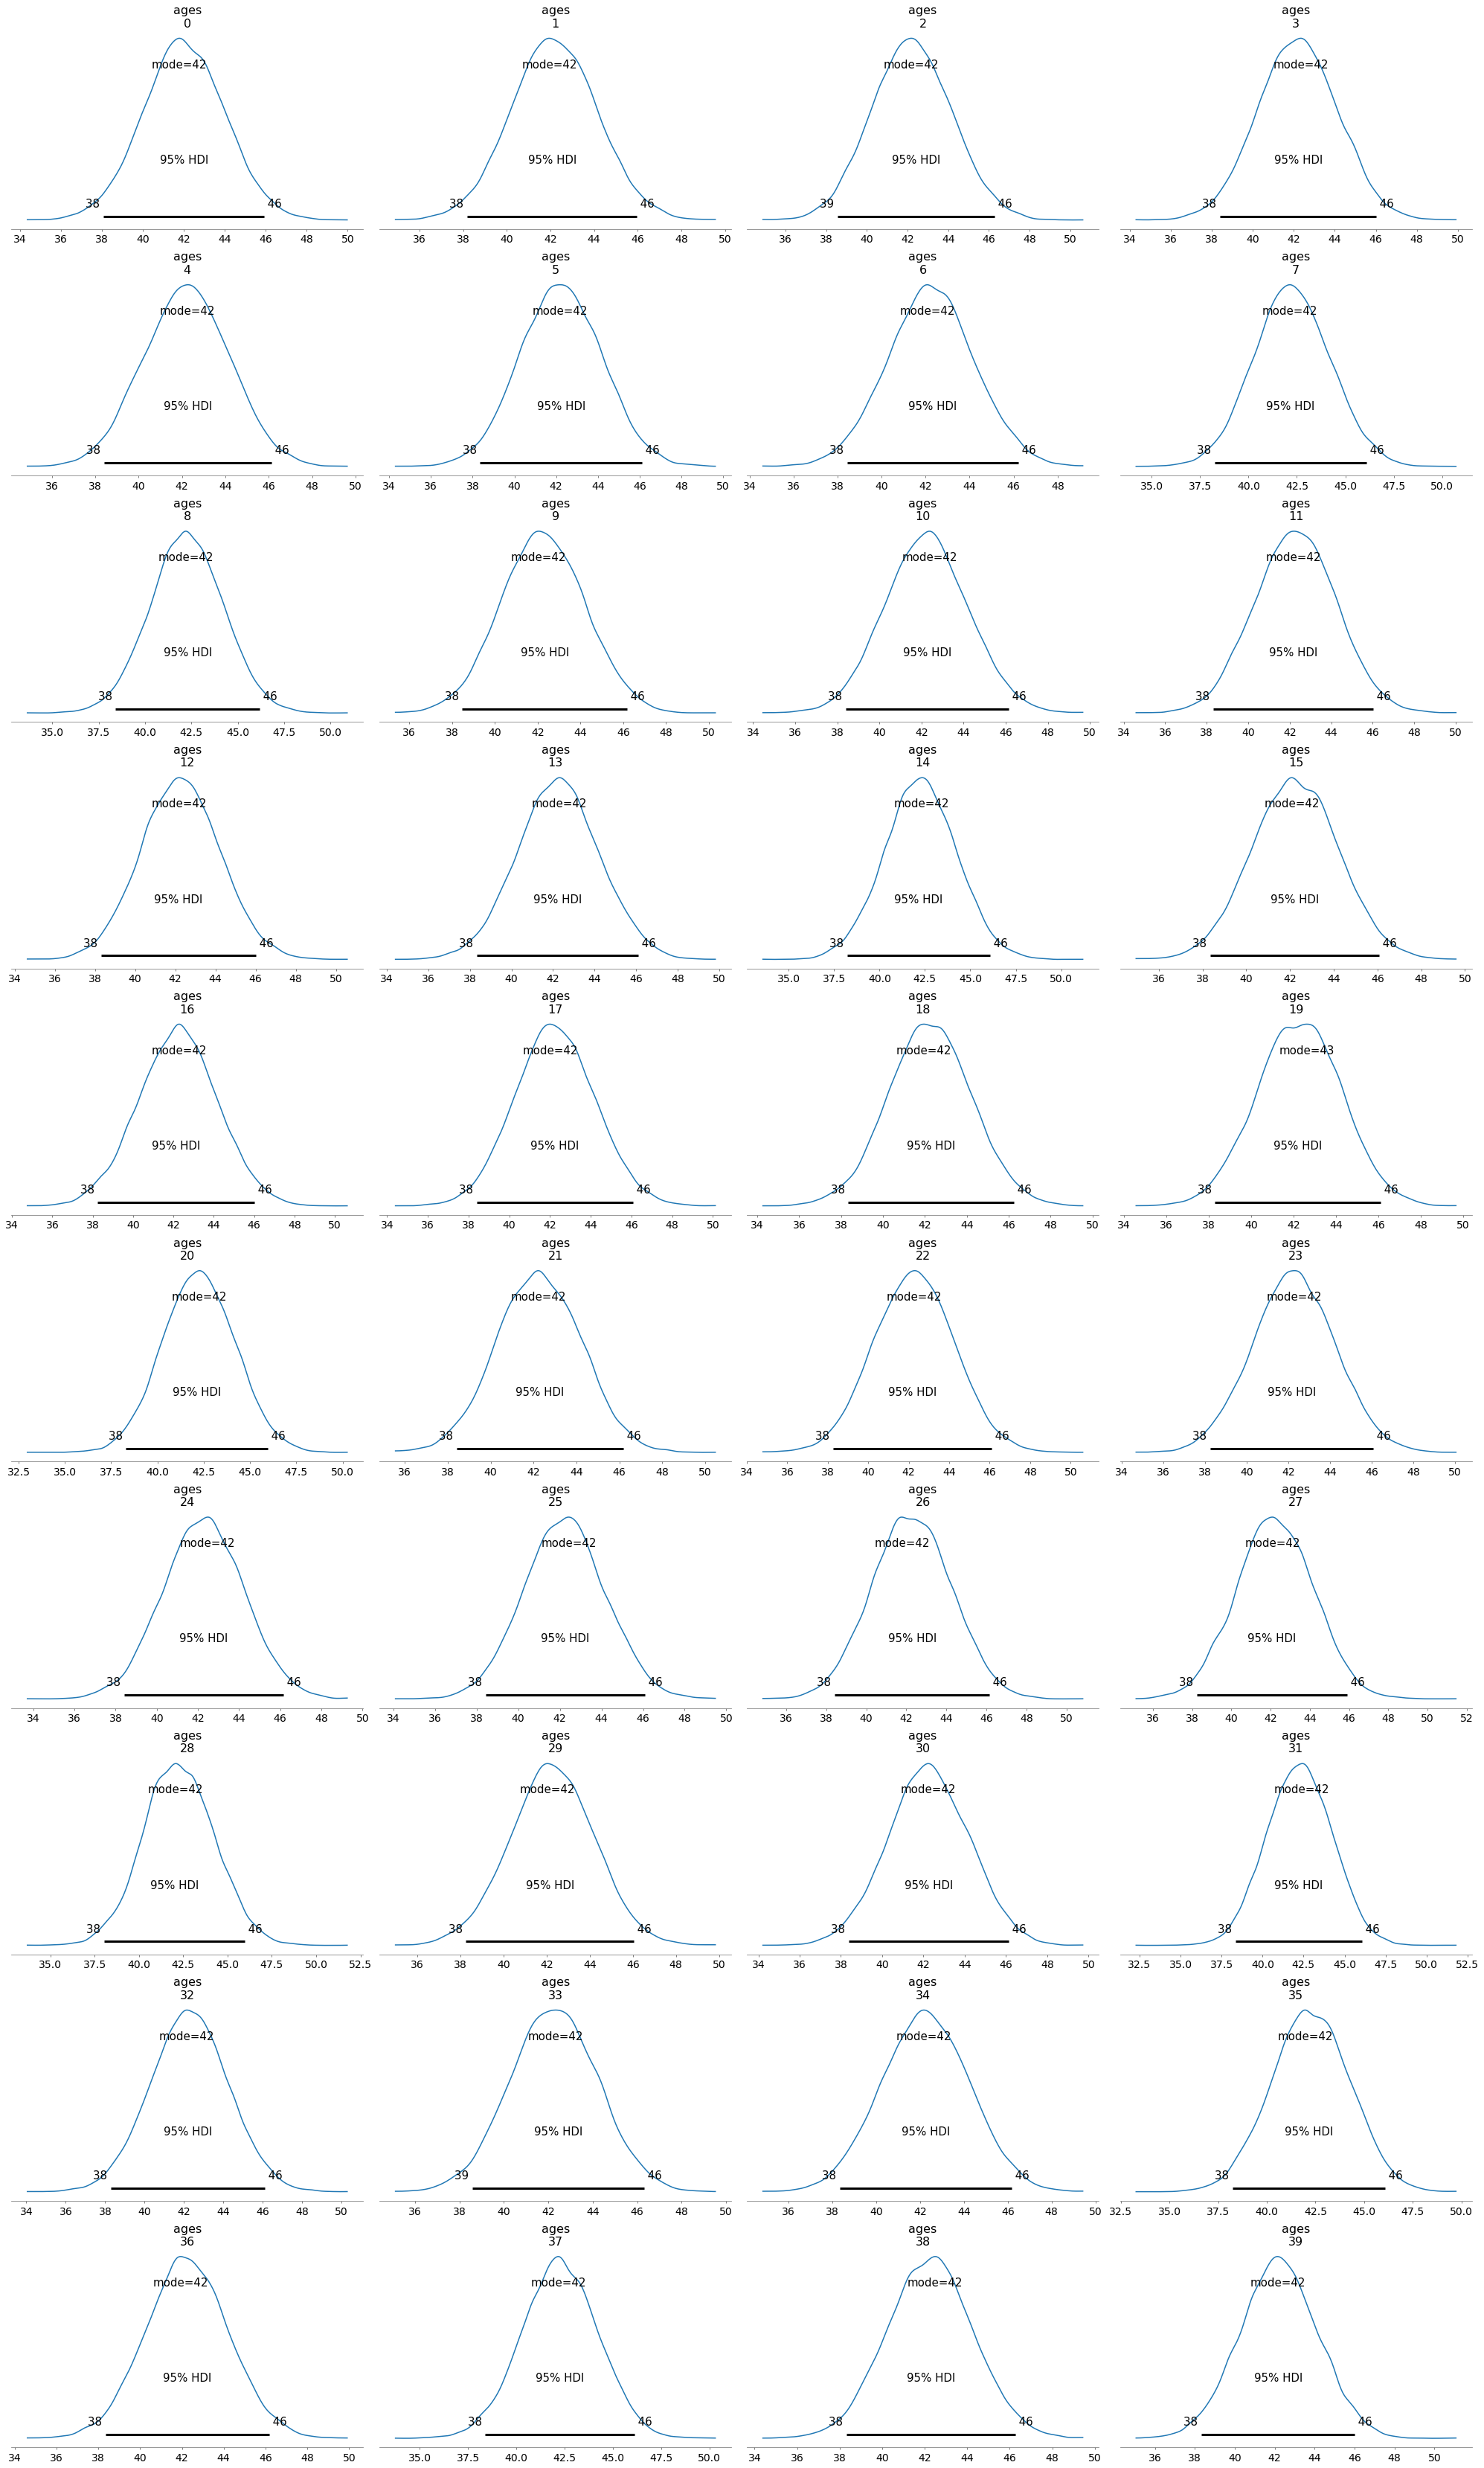

In [9]:
az.plot_posterior(trace, var_names=['ages'], hdi_prob=.95, point_estimate='mode'); # plot the inferred distribution of the output

We can visualize the distribution of a concrete individual to inspect the knowledge of the attacker after observation.

The plot below show that the attacker believes that the most likely age for individual 0 is 42 and considers plausible ages from 38 to 46. The orange line marks the probability of of the age being greater or less than 35. Remember that this was the age that the attacker considered most likely in the prior. Here can observe that, in the posterior, the attacker completely discards 35 as a possible age for individual 0.

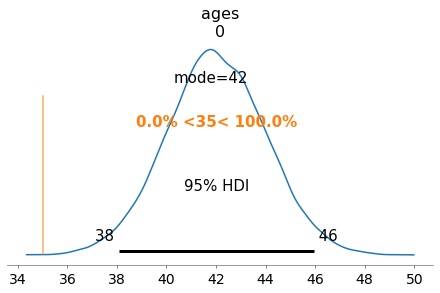

In [10]:
az.plot_posterior(trace,
                  var_names=['ages'],                  
                  coords={'ages_dim_0': [0]},
                  point_estimate='mode',
                  hdi_prob=.95,                      
                  ref_val=35);

#### Prior vs Posterior

We can also visualize the change in knowledge by plotting the prior and posterior distributions of one of the individuals. We do this by extracting the samples of the individual, and, e.g., generating some samples using `scipy` from the prior distribution we chose.

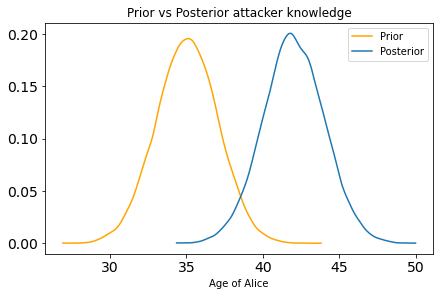

In [11]:
from scipy.stats import norm
posterior_alice_age = trace.posterior['ages'][:,:,0].values.flatten()
prior_alice_age     = norm(loc=35,scale=2).rvs(size=posterior_alice_age.size)

az.plot_dist(prior_alice_age,label='Prior',color='orange')
az.plot_dist(posterior_alice_age,label='Posterior')
plt.title('Prior vs Posterior attacker knowledge')
plt.xlabel('Age of Alice')
plt.legend(loc='best')
plt.show()

These plots show a shift towards ages > 35 from prior to posterior.

In comparing distributions, the difference gives us information about how distant they are. If the difference is 0 with low variance, it means that the prior attacker knowledge did not change after observation. Otherwise, the larger the distance the less accurate the prior attacker knowledge was. A large standard deviation in the difference distribution indicates uncertainty in the conclusion.

There exist other (possibly better) metrics to measure distance between distribution that are supported in privugger, see sections below.

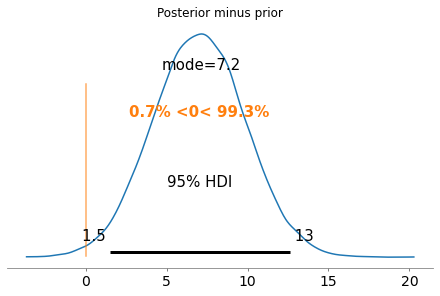

In [12]:
az.plot_posterior(posterior_alice_age-prior_alice_age,
                  point_estimate='mode',
                  hdi_prob=.95,
                  ref_val=0)
plt.title('Posterior minus prior')
plt.show()

### Probability queries and standard statistics

We can also query the traces to obtain to query the distributions and compute standard statistics. 

Note that some of this statistics were already printed in the visualizations.

In [13]:
print('Probability queries')
print('P(age_0<35) = '+str(np.mean(prior_alice_age<35)))
print('P(age_0<35|o≈55) = '+str(np.mean(posterior_alice_age<35)))
print('P(age_0<35 \/ age_0>42|o≈42) = '+str(np.mean((posterior_alice_age<35) | (posterior_alice_age>42))))
print('P(age_0>35 /\ age_0<42|o≈42) = '+str(np.mean((posterior_alice_age>35) & (posterior_alice_age<42))))

print('\n')

print('Standard statistics')
print('E[age_0] = ',np.mean(posterior_alice_age))
print('SD[age_0] = ',np.std(posterior_alice_age))
print('Var[age_0] = ',np.std(posterior_alice_age)**2)
print('95%_HDI[age_0] = ',az.hdi(posterior_alice_age,hdi_prob=.95))

Probability queries
P(age_0<35) = 0.49455
P(age_0<35|o≈55) = 0.00025
P(age_0<35 \/ age_0>42|o≈42) = 0.4969
P(age_0>35 /\ age_0<42|o≈42) = 0.5031


Standard statistics
E[age_0] =  42.00560796391064
SD[age_0] =  2.0007971527482744
Var[age_0] =  4.003189246445602
95%_HDI[age_0] =  [38.07755638 45.93781104]


### Quantitative Information Flow (QIF) metrics

TBW.